In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel
from aggmap import show

In [2]:
dfx  = pd.read_excel('./COVID19.xlsx', sheet_name='data')
dfy  = pd.read_excel('./COVID19.xlsx', sheet_name='sample_info')

dfx = dfx[dfx.columns[1:]]
cols = ["p-%s" % c for c in dfx.columns]
dfx.columns = cols

X = dfx.values
Y = pd.get_dummies(dfy['class']).values.astype(float)

mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0)

2021-06-28 14:35:36,153 - INFO - [bidd-aggmap] - Calculating distance ...
2021-06-28 14:35:36,155 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 88/88 [00:00<00:00, 759.78it/s]


2021-06-28 14:35:36,689 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-06-28 14:35:40,358 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-06-28 14:35:40,376 - INFO - [bidd-aggmap] - Finished


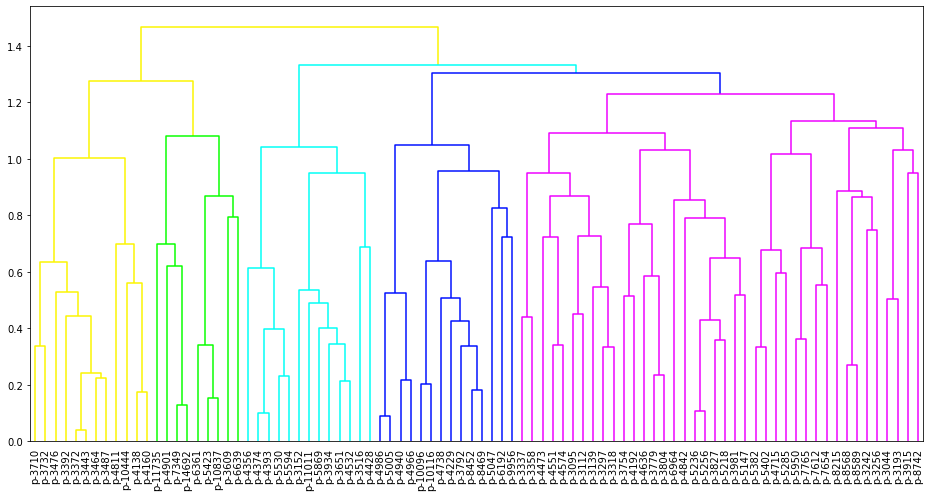

In [3]:
fig_tree = mp.plot_tree(leaf_font_size = 10)
fig_tree.savefig('covid-19.cluster5_tree.png', bbox_inches='tight', dpi=300)

In [4]:
mp.plot_scatter(enabled_data_labels = True, htmlname = 'covid-19.cluster5_scatter',radius=5)

2021-06-28 14:35:47,823 - INFO - [bidd-aggmap] - generate file: ./covid-19.cluster5_scatter_feature points_88_correlation_umap_scatter
2021-06-28 14:35:47,902 - INFO - [bidd-aggmap] - save html file to ./covid-19.cluster5_scatter_feature points_88_correlation_umap_scatter


In [5]:
mp.plot_grid(enabled_data_labels = True, htmlname = 'covid-19.cluster5_grid')

2021-06-28 14:35:47,924 - INFO - [bidd-aggmap] - generate file: ./covid-19.cluster5_grid_feature points_88_correlation_umap_mp
2021-06-28 14:35:47,966 - INFO - [bidd-aggmap] - save html file to ./covid-19.cluster5_grid_feature points_88_correlation_umap_mp


In [6]:
X_new = mp.batch_transform(X, scale_method= 'standard')

100%|##########| 362/362 [00:03<00:00, 119.30it/s]


In [7]:
X_new.shape

(362, 10, 9, 5)

In [8]:
idx = dfy.groupby(['lab', 'class']).apply(lambda x:x.index.tolist())
idx

lab    class   
lab-1  COVID-19    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
       Control     [167, 168, 169, 170, 171, 172, 173, 174, 175, ...
lab-2  COVID-19    [281, 282, 283, 284, 285, 286, 287, 288, 289, ...
       Control     [291, 292, 293, 294, 295, 296, 297, 298, 299, ...
lab-3  COVID-19    [311, 312, 313, 314, 315, 316, 317, 318, 319, ...
       Control     [345, 346, 347, 348, 349, 350, 351, 352, 353, ...
dtype: object

## lab-1

In [86]:
rows = idx.index.tolist()
rows = rows[:2]

lst = []
for row in rows:
    lst.append(idx.loc[row][:n])

lst

[[0, 1, 2, 3, 4, 5], [167, 168, 169, 170, 171, 172]]

In [87]:
dfx1 = dfx.iloc[lst[0]].T
dfx2 = dfx.iloc[lst[1]].T

In [88]:
dfx1.columns = dfx1.columns.map(lambda x:'S%s' % x)
dfx2.columns = dfx2.columns.map(lambda x:'S%s' % x)

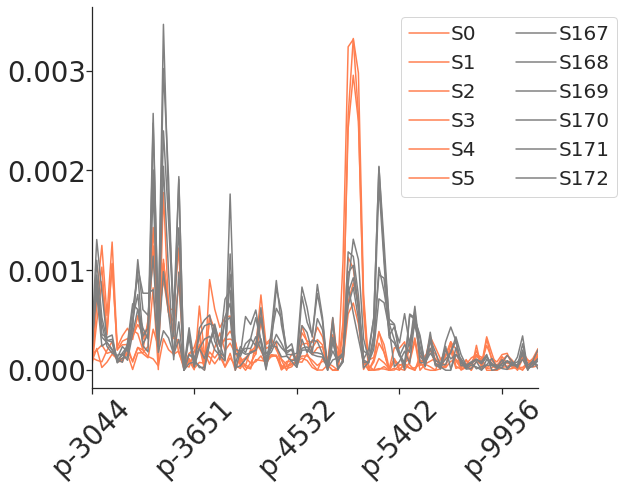

In [100]:
sns.set(font_scale=2.5, style='white')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))

dfx1.plot(ax=ax, color= '#FF7F50' )
dfx2.plot(ax=ax, color='#808080')
ax.legend(ncol=2, fontsize=20, loc = 'upper right', bbox_to_anchor = (1.2, 1), handletextpad=0.1)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.tick_params(axis='x', rotation=45, )

fig.savefig('./lab-1_peak.pdf', bbox_inches='tight', dpi=400) 

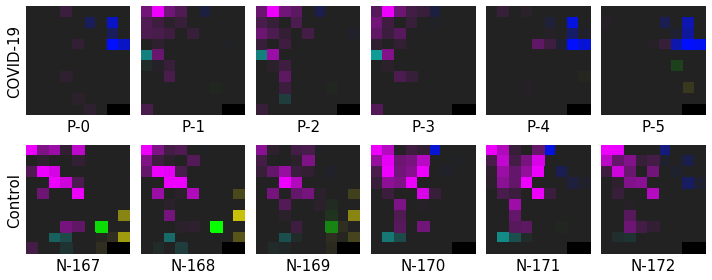

In [11]:
rows = idx.index.tolist()
rows = rows[:2]

n = 6
fontsize = 15

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(10,4), sharex = True, sharey = True)

row_names = [i[1] for i in rows]

for row, row_ax in zip(rows, axes):
    pidx = idx.loc[row][:n]        
    for pid, ax in zip(pidx, row_ax):
        if 'Control' in row:
            pid_name = 'N-%s' % pid
        else:
            pid_name = 'P-%s' % pid
            
        x = X_new[pid]
        #ax.imshow(X_new[pid].sum(axis=-1))
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1, vmin=0.2, vmax=x.max()-0.8)
        ax.set_xlabel(pid_name, fontsize = fontsize) 

for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()
fig.savefig('./lab-1_fmp.png', bbox_inches='tight', dpi=400) 

## lab-2

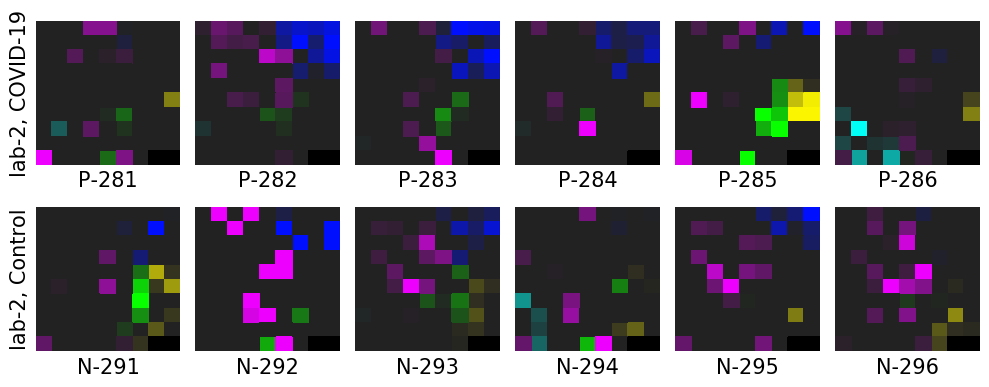

In [12]:
rows = idx.index.tolist()
rows = rows[2:4]

n = 6
fontsize = 15

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(10,4), sharex = True, sharey = True)

row_names = [', '.join(i) for i in rows]

for row, row_ax in zip(rows, axes):
    pidx = idx.loc[row][:n]        
    for pid, ax in zip(pidx, row_ax):
        if 'Control' in row:
            pid_name = 'N-%s' % pid
        else:
            pid_name = 'P-%s' % pid
        x = X_new[pid]
        #ax.imshow(X_new[pid].sum(axis=-1))
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1, vmin=0.2, vmax=x.max()-0.8)
        ax.set_xlabel(pid_name, fontsize = fontsize) 

for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()
fig.savefig('./lab-2_fmp.png', bbox_inches='tight', dpi=400) 

## lab-3

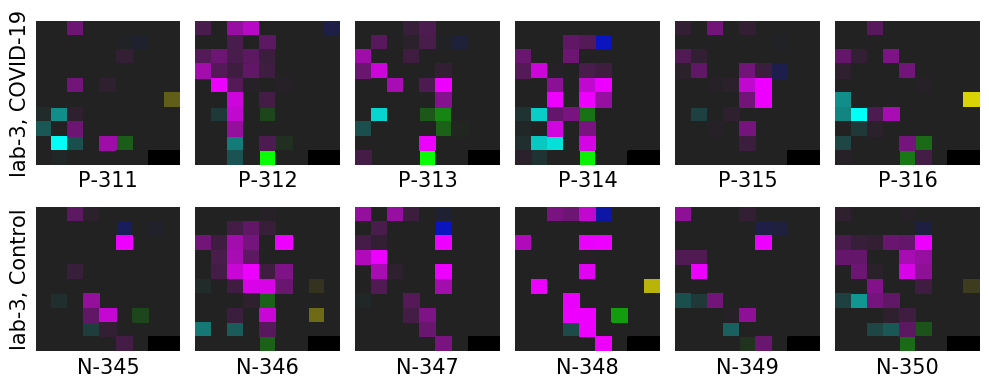

In [13]:
rows = idx.index.tolist()
rows = rows[4:6]

n = 6
fontsize = 15

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(10,4), sharex = True, sharey = True)

row_names = [', '.join(i) for i in rows]

for row, row_ax in zip(rows, axes):
    pidx = idx.loc[row][:n]        
    for pid, ax in zip(pidx, row_ax):
        if 'Control' in row:
            pid_name = 'N-%s' % pid
        else:
            pid_name = 'P-%s' % pid
        x = X_new[pid]
        #ax.imshow(X_new[pid].sum(axis=-1))
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1, vmin=0.2, vmax=x.max()-0.8)
        ax.set_xlabel(pid_name, fontsize = fontsize) 

for ax, row in zip(axes[:,0], row_names):
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()
fig.savefig('./lab-3_fmp.png', bbox_inches='tight', dpi=400) 